# Jupyter Notebook Validation with py.test

One of the powerful uses of Jupyter notebooks is for documentation and examples. But it can be time consuming to check that these notebooks still run correctly as the code they're demonstrating changes.

Nbval is a pluging for the *py.test* test runner, which finds and runs notebooks. This makes it easy to check your notebooks using a *continuous integration* service such as [Travis CI](https://travis-ci.org/).

Nbval does two kinds of checking:

1. Notebooks should run from start to finish without errors. This is a basic but valuable check that your examples aren't broken.

2. Outputs from running the code in the notebook should be the same as the output saved in the notebook file. This can detect if your code is running without errors but doing the wrong thing. However, many kinds of output will be different on each run (e.g. timestamps). Nbval has a number of options to control which outputs it checks.

### Command line usage

Nbval adds a pair of options to py.test: `--nbval-lax` and `--nbval`.

The `--nbval-lax` option enables the basic *run without errors* check, and looks for markers in code cells to check the output from those specific cells (see below).

```
$ py.test --nbval-lax my_notebook.ipynb
```

The `--nbval` option enables the *run without errors* check, and also checks the output of all cells except those with a marker saying that the output should be ignored.

```
$ py.test --nbval my_notebook.ipynb
```

### Examples of plugin behaviour

The following examples demonstrate how the plugin behaves during testing. Test this notebook yourself to see the validation in action!

These imports should produce no output, but if any **warnings** are printed out the output check will fail. Under normal operating conditions this will pass.

In [1]:
import numpy as np
import time

If python doesn't consistently print 7, then something has gone terribly wrong. **Deterministic cells** are expected to pass everytime.

In [2]:
print(5+2)

7


**Random outputs** will always fail the output check.

In [3]:
print([np.random.rand() for i in range(4)])
print([np.random.rand() for i in range(4)])

[0.1414192461385141, 0.1112119568805362, 0.5828182701818883, 0.7972209461690992]
[0.03703472725649182, 0.6605151298230535, 0.644126394220951, 0.01229409143027227]


An **inconsistent number of lines** of output will also fail as an output mismatch.

In [4]:
for i in range(np.random.randint(1, 8)):
    print('a line')

a line
a line
a line
a line


Because the **time and date** will change with each run, we would expect this cell to fail everytime. Using the sanitize file `doc_sanitize.cfg` (see below) you can clean up these outputs.

In [5]:
print('The time is: ' + time.strftime('%H:%M:%S'))
print("Today's date is: " + time.strftime('%d/%m/%y'))

The time is: 16:58:19
Today's date is: 23/06/17


### Prevent output comparison for specific cells

In case we want to avoid the testing process in specific input cells, we can write the comment ** #NBVAL_IGNORE_OUTPUT ** at the
beginning of the them:

In [6]:
# NBVAL_IGNORE_OUTPUT
print('This is not going to be tested')
print(np.random.randint(1, 20000))

This is not going to be tested
1143


### Challenge 1

Test this notebook with the `--nbval` option. How many cells fail?

Use the marker comment in non-deterministic cells, and re-test the notebook to check that it now passes.

### Enforce output comparison

There's also a counterpart, to ensure the output is tested even when using `--nbval-lax` :

In [7]:
# NBVAL_CHECK_OUTPUT
print("This will be tested")
print(6 * 7)

This will be tested
42


## Challenge 2

Test this notebook with `--nbval-lax`. There should be no test failures.

Which cells would you want to check the output for? Add some more marker comments to enable output checking with `--nbval-lax`.

### Skipping specific cells

If, for some reason, a cell should not be executed during testing, the comment **# NBVAL_SKIP** can be used:

```python
# NBVAL_SKIP
print("Entering infinite loop...")
while True:
    pass
```

### Checking exceptions

Sometimes, we might want to allow a notebook cell to raise an exception, and check that the traceback is as we expect.  By annotating the cell with the comment ** # NBVAL_RAISES_EXCEPTION ** you can indicate that the cell is expected to raise an exception.

Nbval checks that the error type (e.g. `RuntimeError`) is the same, but it doesn't compare the traceback, because file paths will often be different.

In [8]:
# NBVAL_RAISES_EXCEPTION
print("This exception will be tested")
raise RuntimeError("Foo")

This exception will be tested


RuntimeError: Foo

This composes with the output checking comments, so if you would like to avoid exceptions creating a test failure, but don't want to check the error type, use `# NBVAL_IGNORE_OUTPUT` as well.

In [11]:
# NBVAL_RAISES_EXCEPTION
print("If the raised exception doesn't match the stored exception, we get a failure")
raise = RuntimeError("Foo")

If the raised exception doesn't match the stored exception, we get a failure


RuntimeError: Foo

In [12]:
# NBVAL_IGNORE_OUTPUT
# NBVAL_RAISES_EXCEPTION
print("This exception will not be checked, but will not cause a failure.")
raise RuntimeError("Bar")

This exception will not be checked, but will not cause a failure.


RuntimeError: Bar

### Using tags instead of comments

If you do not want to put nbval comment annotations in your notebook, or your source language is not compatible with such annotations, you can use cell tags instead. Cell tags are strings that are added to the cell metadata under the label "tags", and can be edited by selecting *View → Cell Toolbar → Tags*.

![cell with nbval-check-output tag](images/nbval_cell_tag.png)

The tags which nbval recognises are the same as the comment names, but lowercase and with dashes ('-') instead of underscores ('_').

### Figures

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

Currently, only the matplotlib text output of the Figure is compared, but it is possible to modify the plugin to allow comparison of the image whole string.

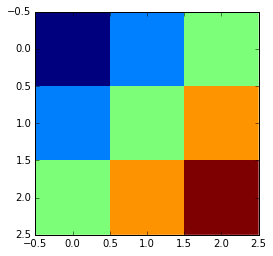

In [10]:
plt.imshow(np.array([[i + j for i in range(3)]
                     for j in range(3)]),
           interpolation='None'
           )

### Regex Output sanitizing

Some pesky messages in the output (time-stamped messages, for example) may be different on every run, causing output comparisons to fail. The plugin allows the user to specify a sanitizing file at the command prompt using the following flag:

```
$ py.test --nbval my_notebook.ipynb --sanitize-with my_sanitize_file
```

This sanitize file contains a number of regex replacements. It is recommended, when removing output for the tests, that you replace the removed output with some sort of marker to help with debugging. The following file is written to the folder of this notebook and can be used to santize its outputs:

In [1]:
%%writefile doc_sanitize.cfg
[regex1]
regex: \d{1,2}/\d{1,2}/\d{2,4}
replace: DATE-STAMP

[regex2]
regex: \d{2}:\d{2}:\d{2}
replace: TIME-STAMP

Writing doc_sanitize.cfg


The first replacement finds dates in the given format replaces them with the label 'DATE-STAMP', likewise for strings that look like time. These will prevent the tests from failing due to time differences.

For more information on regular expressions, see Python's [re module documentation](https://docs.python.org/3/library/re.html).

### Validate this notebook

You can validate this notebook yourself, as shown below; the outputs that you see here are stored in the ipynb file. If your system produces different outputs, the testing process will fail. Just use the following commands:
```
$ cd /path/to/this/notebook
$ py.test --nbval documentation.ipynb --sanitize-with doc_sanitize.cfg
```